# Lab 04: Feature Engineering

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

from seaborn import heatmap

In [3]:
df = pd.read_csv("../datasets/dataset_concrete.csv")

df = df.sample(frac=1, random_state=2)
df.reset_index(drop=True, inplace=True)
dev_df, test_df = train_test_split(df, train_size=0.8, random_state=2)

In [4]:
dev_df.shape

(824, 9)

In [5]:
dev_df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age', 'strength'],
      dtype='object')

In [6]:
dev_df.dtypes

cement              float64
slag                float64
fly_ash             float64
water               float64
superplasticizer    float64
coarse_aggregate    float64
fine_aggregate      float64
age                   int64
strength            float64
dtype: object

In [7]:
copy_df = dev_df.copy()

<Axes: >

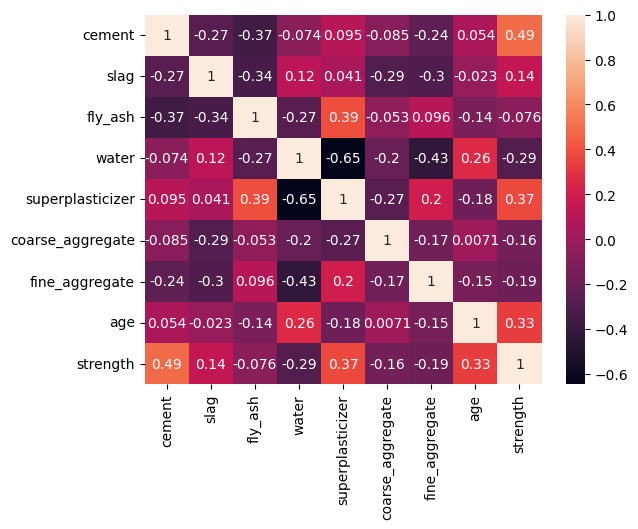

In [8]:
heatmap(copy_df[copy_df.columns].corr(), annot=True)

In [9]:
# Google research showed that cement/water ratio impacts strength
class InsertCementWaterRatio(BaseEstimator, TransformerMixin):

    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.insert:
            X["cement_water_ratio"] = X["water"] / X["cement"]
            X = X.replace([np.inf, -np.inf], np.nan)
        return X

In [10]:
# Concrete gets stronger with age, thus look at the exponential relationship between strength and age
class InsertLogAge(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.insert:
            X["log_age"] = np.log(X["age"])
            X = X.replace([np.inf, -np.inf], np.nan)
        return X

In [11]:
class InsertAggregateRatio(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.insert:
            X["aggregate_ratio"] = X["fine_aggregate"] / X["coarse_aggregate"]
            X = X.replace([np.inf, -np.inf], np.nan)
        return X

In [12]:
class InsertTotalBinderContent(BaseEstimator, TransformerMixin):
    def __init__(self, insert=True):
        self.insert = insert

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.insert:
            X["total_binder_content"] = X["cement"] + X["slag"] + X["fly_ash"]
            X = X.replace([np.inf, -np.inf], np.nan)
        return X

In [13]:
class ScalerSelector(BaseEstimator, TransformerMixin):

    def __init__(self, scaler=None):
        self.scaler = scaler

    def fit(self, X, y=None):
        if self.scaler:
            self.scaler.fit(X, y)
        return self

    def transform(self, X, y=None):
        if self.scaler:
            return self.scaler.transform(X)
        else:
            return X

In [14]:
features = [
    "cement",
    "slag",
    "fly_ash",
    "water",
    "superplasticizer",
    "coarse_aggregate",
    "fine_aggregate",
    "age",
]

train_val_X = dev_df[features]
train_val_y = dev_df["strength"].values

test_X = test_df[features]
test_y = test_df["strength"].values

In [15]:
preprocessor = ColumnTransformer(
    [
        (
            "num",
            Pipeline(
                [
                    ("cement_water_ratio", InsertCementWaterRatio()),
                    ("log_age", InsertLogAge()),
                    ("aggregate_ratio", InsertAggregateRatio()),
                    ("total_binder_content", InsertTotalBinderContent()),
                    ("imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
                    ("scaler", ScalerSelector()),
                    ("feature_selection", RFE(estimator=LinearRegression())),
                ]
            ),
            features,
        ),
    ],
    remainder="drop",
)

In [16]:
knn = Pipeline([("preprocessor", preprocessor), ("predictor", KNeighborsRegressor())])

### K-Fold

In [17]:
param_grid = {
    "predictor__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "preprocessor__num__cement_water_ratio__insert": [True, False],
    "preprocessor__num__log_age__insert": [True, False],
    "preprocessor__num__aggregate_ratio__insert": [True, False],
    "preprocessor__num__total_binder_content__insert": [True, False],
    "preprocessor__num__scaler__scaler": [
        StandardScaler(),
        MinMaxScaler(),
        RobustScaler(),
    ],
    "preprocessor__num__feature_selection__n_features_to_select": [2, 3, 4, 5, 6, 7, 8],
}

In [18]:
gs = GridSearchCV(knn, param_grid, scoring="neg_mean_absolute_error", cv=10, refit=True)

In [19]:
gs.fit(train_val_X, train_val_y)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('cement_water_ratio',
                                                                                          InsertCementWaterRatio()),
                                                                                         ('log_age',
                                                                                          InsertLogAge()),
                                                                                         ('aggregate_ratio',
                                                                                          InsertAggregateRatio()),
                                                                                         ('total_binder_content',
                                                                                          InsertTotalBinderContent()),
                                                                                         ('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          ScalerSelector()),
                                                                                         ('featur...
                         'preprocessor__num__cement_water_ratio__insert': [True,
                                                                           False],
                         'preprocessor__num__feature_selection__n_features_to_select': [2,
                                                                                        3,
                                                                                        4,
                                                                                        5,
                                                                                        6,
                                                                                        7,
                                                                                        8],
                         'preprocessor__num__log_age__insert': [True, False],
                         'preprocessor__num__scaler__scaler': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler()],
                         'preprocessor__num__total_binder_content__insert': [True,
                                                                             False]},
             scoring='neg_mean_absolute_error')

In [201]:
gs.best_params_

{'predictor__n_neighbors': 1,
 'preprocessor__num__aggregate_ratio__insert': False,
 'preprocessor__num__cement_water_ratio__insert': True,
 'preprocessor__num__feature_selection__n_features_to_select': 6,
 'preprocessor__num__log_age__insert': True,
 'preprocessor__num__scaler__scaler': RobustScaler(),
 'preprocessor__num__total_binder_content__insert': False}

In [20]:
mean_absolute_error(test_y, gs.predict(test_X))

4.1369417475728145

Original MAE: 6.2957767
Cement Water Ratio added: No change
Cement Water Ratio and log of age: 4.56694
Cement Water Ratio and log of age, with features selected = 5: 4.1495
Cement Water Ratio and log of age, with features selected = 5, using RobustScaler(): 4.1369

### Shuffle-Split - Holdout

In [154]:
ss = ShuffleSplit(n_splits=1, train_size=0.75, random_state=2)

In [155]:
gs2 = GridSearchCV(knn, param_grid, scoring="neg_mean_absolute_error", cv=ss)

# Run grid search by calling fit
gs2.fit(train_val_X, train_val_y)

/Users/jackmoloney/Developer/artificial_intelligence_2024_2025/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=11 > n_features=10. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/jackmoloney/Developer/artificial_intelligence_2024_2025/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=12 > n_features=11. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/jackmoloney/Developer/artificial_intelligence_2024_2025/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=12 > n_features=10. There will be no feature selection and all features will be kept.
  warnings.warn(
/Users/jackmoloney/Developer/artificial_intelligence_2024_2025/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_fe

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=2, test_size=None, train_size=0.75),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('cement_water_ratio',
                                                                                          InsertCementWaterRatio()),
                                                                                         ('log_age',
                                                                                          InsertLogAge()),
                                                                                         ('aggregate_ratio',
                                                                                          InsertAggregateRatio()),
                                                                                         ('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardSc...
             param_grid={'predictor__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                    10, 11, 12, 13, 14, 15],
                         'preprocessor__num__aggregate_ratio__insert': [True,
                                                                        False],
                         'preprocessor__num__cement_water_ratio__insert': [True,
                                                                           False],
                         'preprocessor__num__feature_selection__n_features_to_select': [2,
                                                                                        3,
                                                                                        4,
                                                                                        5,
                                                                                        6,
                                                                                        7,
                                                                                        8,
                                                                                        9,
                                                                                        10,
                                                                                        11,
                                                                                        12],
                         'preprocessor__num__log_age__insert': [True, False]},
             scoring='neg_mean_absolute_error')

In [156]:
gs2.best_params_

{'predictor__n_neighbors': 2,
 'preprocessor__num__aggregate_ratio__insert': True,
 'preprocessor__num__cement_water_ratio__insert': True,
 'preprocessor__num__feature_selection__n_features_to_select': 6,
 'preprocessor__num__log_age__insert': True}

In [157]:
mean_absolute_error(test_y, gs2.predict(test_X))

4.677063106796116

## Linear Model

In [15]:
linear_model = Pipeline(
    [("preprocessor", preprocessor), ("predictor", LinearRegression())]
)
linear_model.fit(train_val_X, train_val_y)
mean_absolute_error(test_y, linear_model.predict(test_X))

8.407187476302653

# Visual

In [ ]:
## GENERATED BY CHAT-GPT ##
# Predictions from the models
knn_pred = gs.predict(test_X)
knn2_pred = gs2.predict(test_X)
linear_pred = linear_model.predict(test_X)

# Plotting
plt.figure(figsize=(12, 6))

# KNN with best params from K-Fold
plt.subplot(1, 3, 1)
plt.scatter(test_y, knn_pred, alpha=0.5)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], "k--", lw=2)
plt.title("KNN (K-Fold)")
plt.xlabel("True Values")
plt.ylabel("Predictions")

# KNN with best params from Shuffle-Split
plt.subplot(1, 3, 2)
plt.scatter(test_y, knn2_pred, alpha=0.5)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], "k--", lw=2)
plt.title("KNN (Shuffle-Split)")
plt.xlabel("True Values")
plt.ylabel("Predictions")

# Linear Regression
plt.subplot(1, 3, 3)
plt.scatter(test_y, linear_pred, alpha=0.5)
plt.plot([test_y.min(), test_y.max()], [test_y.min(), test_y.max()], "k--", lw=2)
plt.title("Linear Regression")
plt.xlabel("True Values")
plt.ylabel("Predictions")

plt.tight_layout()
plt.show()

# Create new features